# Антиспам

In [299]:
from __future__ import division

import base64
import csv
import gzip
import zlib
from importlib import reload
import html.parser
from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

### функции для обработки текста

In [300]:
!pip install pymorphy2
import pymorphy2   
  
def pos(word, morth=pymorphy2.MorphAnalyzer()):
    "Return a likely part of speech for the *word*."""
    return morth.parse(word)[0].tag.POS

In [301]:
list_mest = ['я', 'ты', 'он', 'она', 'оно', 'мы',
             'вы', 'они','мой', 'твой', 'свой', 'ваш', 'наш', 'его', 'её', 'их',
            'все','быть','может', 'можно', 'очень','нужно','будет','уже','могут',
            'кто', 'что', 'какой', 'чей', 'где', 'который', 'откуда', 'сколько', 'каковой', 'каков', 'зачем',
            'меня','мне','того', 'этого', 'этот','ее','вы','более', 'было', 'вам', 'все', 'вы',  
             'которые', 'нет',  'том', 'этом',
            'вас', 'вообще', 'всего', 'вы',
            'себе', 'себя', 'ему', 'тебе', 'тебя','был']

In [302]:
morph = pymorphy2.MorphAnalyzer()

In [303]:

import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [304]:

from nltk.corpus import stopwords
# from pymystem3 import Mystem
from string import punctuation

In [264]:
russian_stopwords = stopwords.words("russian")
functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP'}  

In [265]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [305]:
def to_utf8(text):
    if isinstance(text, str): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        try:
            if not isinstance(text, str): text = text.decode('utf8')
            return f(text)
        except:
            print('!')
    return tmp

def convert2lower(f):
    def tmp(text):        
        if text:
            return f(text.lower())
        else:
            return f(text)
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [306]:
# from HTMLParser import HTMLParser
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False
        self._num_links = 0
        self._link = True
        self._list_link = []
        self._anchor = ""
        self._img = False
        self._num_img = 0
        self._num_css = 0
        self._script = False
        self._num_script = 0

        self._mlist = False
        self._num_list = 0
        self._num_css = 0
        self._css = False

        # self._video = False   бесполезно
        # self._num_video = 0
        # self._audio = False
        # self._num_audio = 0
        
        self._table = False
        self._num_table = 0
        
    def handle_data(self, data):
        
        text = data.strip()
        if self._in_title:
            self._title += text
            self._in_title = False

        if self._link:
            self._num_links += 1
            self._link = False
            self._anchor += text + " "
            
        if self._img:
            self._num_img += 1
            self._img = False
        if self._script:
            self._num_script += 1
            self._script = False
        if self._mlist:
            self._num_list += 1
            self._mlist = False
        if self._css:
            self._num_css += 1
            self._css = False
        # if self._video:
        #     self._num_video += 1
        #     self._video = False
        # if self._audio:
        #     self._num_audio += 1
        #     self._audio = False
        if self._table:
            self._num_table += 1
            self._table = False
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True
        elif tag == 'a':
            self._link = True 
        elif tag == 'img':
            self._img = True  
        elif tag == 'ul' or tag == 'ol' or tag == 'dl':
            self._mlist = True
        # elif tag == 'video':
        #     self._video = True 
        elif tag == 'script':
            self._script = True 
        # elif tag == 'audio':
        #     self._audio = True 
        elif tag == 'table':
            self._table = True 
        elif tag == 'link':
            self._css = True


    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text(), parser._title, parser._num_links , parser._anchor, parser._num_img,\
            parser._num_script, parser._num_table, parser._num_list, parser._num_css

#### Извлечение текста при помощи дополнительных библиотек

In [307]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [308]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [309]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [310]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    p = to_text(raw_html)
    if p:
        text, title, num_links , anchor,num_img, num_script,  num_table, num_list, num_css = to_text(raw_html)

        return text,title,num_links,anchor,num_img, num_script, num_table, num_list, num_css
    else:
        return None

#### Рассчет финальных метрик

In [311]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print ('threshold %s' % threshold)
            print ('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print ('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print ('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [312]:
from __future__ import division
import requests
import urllib.request
import http.client

AllTexts = []  # список всех текстов(для подсчета дополнительных фичей)


def calc_features(url, html_data, compression_lvl):
    
    
    if html2word(html_data):
        text, title, num_links , anchor, num_img, num_script, num_table, num_list, num_css = html2word(html_data)
        words = [ i for i in text.expandtabs().split(' ') if i!=" "]
        words_num = len(words)
        
        avg_word_len = len(text) / words_num
        title_words_num = len(title)   
        anchor_words_num = len([i for i in anchor.expandtabs().split(' ') if i!=" "])
        url_len = len(url)
        html = int(url.find("html")!=-1)
        tire = len(url.split('-')) - 1
        AllTexts.append(text[:10000])
    else:
        tire = len(url.split('-')) - 1
        html = int(url.find("html")!=-1)
        url_len = len(url)

        num_css = 0
        num_links = 0
        words = None
        words_num = 0
        num_img=0
        num_script=0
        # num_video=0
        # num_audio=0
        num_table=0
        avg_word_len = 0
        title_words_num = 0   
        anchor_words_num = 0
        num_list = 0
        AllTexts.append([])

    return [words_num,  # Количество слов на странице
            avg_word_len, # Средняя длинна слова
            title_words_num,  # Количество слов в заголовке страниц 
            anchor_words_num,  # Количество слов в анкорах ссылок
            compression_lvl,  # Коэффициент сжатия
            num_links,  # Количество ссылок
            num_img,  # Количество картинок
            num_script,  # Количество скриптов
            num_table,  # Количество таблиц
            num_list,  # Количество списков
            num_css,  # Количество css
            url_len,  # Длина урла
            tire,  # Количество тире в урле
            html]  # присутствие html
        

In [313]:
import tqdm
#предобраюотка текста для подсчета tf, idf
def obr_texts(AllTexts2):
    ready_all_texts = []
    for text in tqdm.tqdm(AllTexts2):
        if text:
          r = [ i.lower() for i in text.split(' ') if i]
          p = [re.sub(r'[^А-я]', '', i) for i in r]
          p1 = list(filter(lambda i: i, p))
          cur = [word for word in p1 if (pos(word) not in functors_pos and len(word)>1)]
          cur = [u.lower() for u in cur if not u.lower() in list_mest]             
          cur = [i for i in cur if (not i in russian_stopwords) and i]
          cur = [morph.parse(o)[0].normal_form for o in cur]
          ready_all_texts.append(' '.join(cur))
    else:
          ready_all_texts.append("")
        
    return ready_all_texts

In [314]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
def idf(ready_all_texts,max_featurescur):
    vectorizer = TfidfVectorizer(max_features=max_featurescur)
    X6 = vectorizer.fit_transform(ready_all_texts)
    idf = np.mean(X6, axis=-1)
    return idf

In [160]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data,0)
print( test_features)

[6, 4.333333333333333, 15, 2, 0, 1, 0, 0, 0, 0, 0]


In [315]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
#             parts = line.strip().split('\t')
            parts = line.decode(encoding = 'utf-8',errors = 'strict').strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            compression_lvl = (len(pageInb64) / len(html_data) - 1.333) * 100000 - 30
            features = calc_features_f(url, html_data, compression_lvl)   
            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)        

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [316]:
%%time

TRAIN_DATA_FILE  = '/content/drive/My Drive/antispam-infopoisk/kaggle_train_data_tab_new.csv.gz'

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))

15:11:37 INFO:Complete items 00000
15:12:17 INFO:Complete items 01000
15:12:52 INFO:Complete items 02000
15:13:27 INFO:Complete items 03000


!


15:14:02 INFO:Complete items 04000
15:14:40 INFO:Complete items 05000
15:15:16 INFO:Complete items 06000
15:15:52 INFO:Complete items 07000
15:15:53 INFO:Complete items 07043


CPU times: user 4min 15s, sys: 303 ms, total: 4min 15s
Wall time: 4min 16s


In [29]:
r_a_t = obr_texts(AllTexts) # предобработка текста

100%|██████████| 7045/7045 [27:27<00:00,  4.28it/s]


In [31]:
import pickle #
with open('/content/drive/My Drive/antispam-infopoisk/text2.data', 'wb') as filehandle:
    pickle.dump(r_a_t,filehandle)

In [32]:
with open('/content/drive/My Drive/antispam-infopoisk/text2.data', 'rb') as filehandle:
    r_a_t2 = pickle.load(filehandle)

In [192]:
Idf5 = idf(r_a_t2,5)
Idf10 = idf(r_a_t2,10)
Idf20 = idf(r_a_t2,20)

In [242]:
Idf15 = idf(r_a_t2,15)
Idf3 = idf(r_a_t2,3)

In [317]:
#добавляем усредненный idf и tf к признакам
i=0
for doc in train_docs:
  doc.features.append(Idf10[i].tolist()[0][0])
  doc.features.append(Tf20[i])
  i+=1

In [166]:
from sklearn.feature_extraction.text import CountVectorizer
def tf(ready_all_texts,max_featurescur):
  vectorizer = CountVectorizer(max_features=max_featurescur).fit_transform(ready_all_texts)
  vectores = vectorizer.toarray()
  tf = np.mean(vectores, axis=-1)
  return tf

In [167]:
Tf5 = tf(r_a_t2,5)
Tf10 = tf(r_a_t2,10)
Tf15 = tf(r_a_t2,15)
Tf20 = tf(r_a_t2,20)


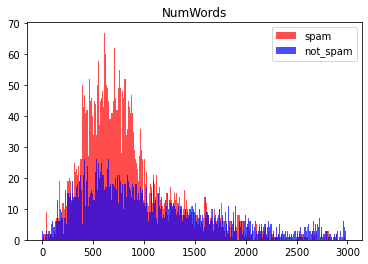

In [229]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue',  alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

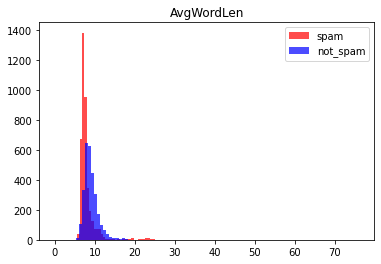

In [230]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue',  alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

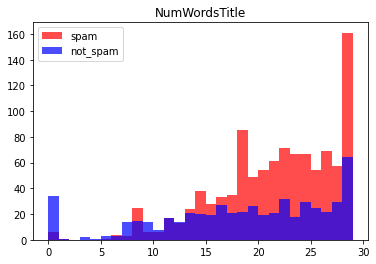

In [231]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue',  alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

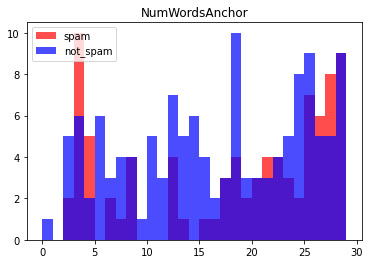

In [232]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', alpha=0.7, label='not_spam')
plt.title('NumWordsAnchor')
plt.legend()
plt.show()

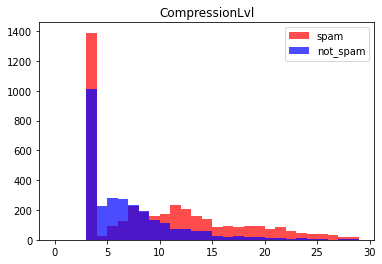

In [233]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue',  alpha=0.7, label='not_spam')
plt.title('CompressionLvl')
plt.legend()
plt.show()

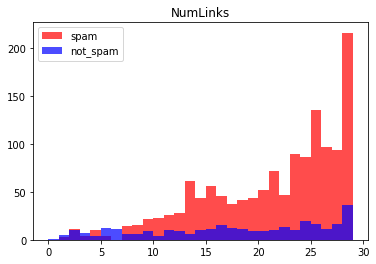

In [234]:
#Добавить графики для остальных фичей
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue',  alpha=0.7, label='not_spam')
plt.title('NumLinks')
plt.legend()
plt.show()

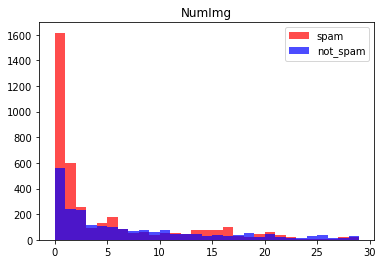

In [235]:
is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', alpha=0.7, label='not_spam')
plt.title('NumImg')
plt.legend()
plt.show()

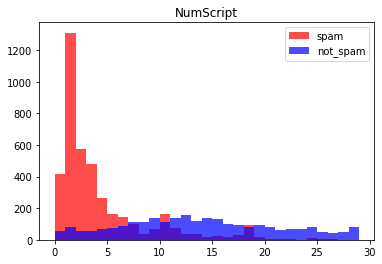

In [236]:
is_spam_data = [doc.features[7] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[7] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', alpha=0.7, label='not_spam')
plt.title('NumScript')
plt.legend()
plt.show()

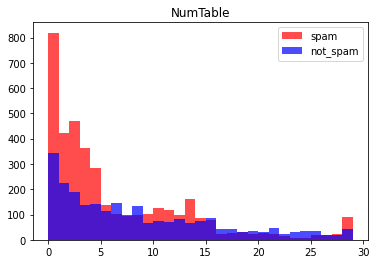

In [ ]:
is_spam_data = [doc.features[8] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[8] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', alpha=0.7, label='not_spam')
plt.title('NumTable')
plt.legend()
plt.show()

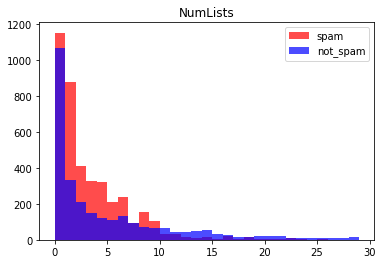

In [ ]:
is_spam_data = [doc.features[9] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[9] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', alpha=0.7, label='not_spam')
plt.title('NumLists')
plt.legend()
plt.show()

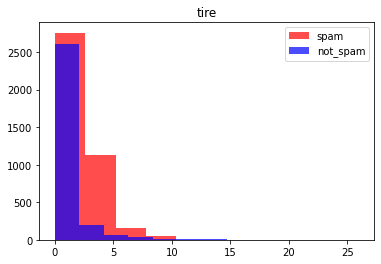

In [286]:
is_spam_data = [doc.features[12] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[12] for doc in train_docs if doc[1] == False]
# bins = range(0, 30, 1)
plt.hist(is_spam_data,  color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data,  color='blue', alpha=0.7, label='not_spam')
plt.title('tire')
plt.legend()
plt.show()

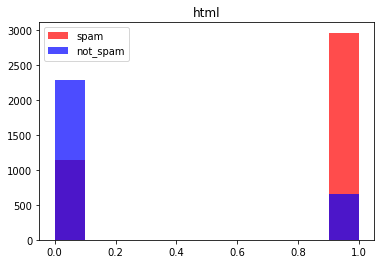

In [318]:
is_spam_data = [doc.features[13] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[13] for doc in train_docs if doc[1] == False]
# bins = range(0, 30, 1)
plt.hist(is_spam_data,  color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data,  color='blue', alpha=0.7, label='not_spam')
plt.title('html')
plt.legend()
plt.show()

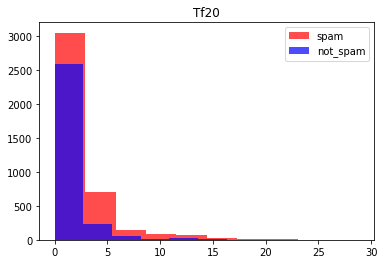

In [52]:
is_spam_data = [Tf20[i] for i,doc in zip(range(len(train_docs)),train_docs) if doc[1] == True]
not_spam_data = [Tf20[i] for i,doc in zip(range(len(train_docs)),train_docs) if doc[1] == False]
# bins = range(0, 30, 1)
plt.hist(is_spam_data,  color='red',  alpha=0.7, label='spam')
plt.hist(not_spam_data,  color='blue', alpha=0.7, label='not_spam')
plt.title('Tf20')
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать

In [168]:
import torch.optim as optim
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output

In [319]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
class Classifier:
    
    def __init__(self):
        self.clf = GradientBoostingClassifier(n_estimators=1500)


    def predict(self, doc):        
        return self.clf.predict([doc.features])                   
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def train(self, docs):        
        all_features = np.array([])
        all_labels = np.array([])
        for doc_num, doc in enumerate(docs): 
            
            try:
                all_features = np.append(all_features,np.array(doc.features))
                all_labels = np.append(all_labels,np.array(doc.is_spam))
            except:
                print(doc)
            trace(doc_num)
        trace(doc_num, 1)
#         print(all_features.shape,all_labels.shape)
#         print(all_features.reshape(all_labels.shape[0],-1)[:5],all_features[:20])
#         print(all_labels[:5])
        self.clf.fit(all_features.reshape(all_labels.shape[0],-1), all_labels)


In [320]:
classifier = Classifier()
classifier.train(train_docs)

15:18:14 INFO:Complete items 00000
15:18:14 INFO:Complete items 01000
15:18:14 INFO:Complete items 02000
15:18:14 INFO:Complete items 03000
15:18:14 INFO:Complete items 04000
15:18:14 INFO:Complete items 05000
15:18:14 INFO:Complete items 06000
15:18:15 INFO:Complete items 07000
15:18:15 INFO:Complete items 07043


(112704,) (7044,)
[[3.14500000e+03 8.30588235e+00 3.30000000e+01 1.63000000e+02
  3.33333333e+00 6.00000000e+01 1.00000000e+00 7.00000000e+00
  1.00000000e+00 3.00000000e+00 0.00000000e+00 2.80000000e+01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.90000000e+02 9.55362319e+00 1.90000000e+01 2.05000000e+02
  3.33333333e+00 8.10000000e+01 0.00000000e+00 1.10000000e+01
  0.00000000e+00 1.40000000e+01 0.00000000e+00 5.00000000e+01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.00000000e-01]
 [1.24300000e+03 8.07401448e+00 4.40000000e+01 4.29000000e+02
  6.33194647e+00 1.39000000e+02 2.00000000e+00 1.40000000e+01
  3.80000000e+01 0.00000000e+00 0.00000000e+00 4.10000000e+01
  2.00000000e+00 1.00000000e+00 1.34315108e-01 6.00000000e-01]
 [7.29000000e+02 9.70507545e+00 1.90000000e+01 1.24000000e+02
  3.33333333e+00 7.30000000e+01 6.00000000e+00 9.00000000e+00
  5.00000000e+01 0.00000000e+00 0.00000000e+00 3.80000000e+01
  0.00000000e+00 0.00000000e+00 1.19017257e-01 2.

In [62]:
#Посмотреть, что предсказывается для тестового html
print(test_features)
classifier.predict(DocItem(0, 0, test_url , test_features+[0]+[0]))

[6, 4.333333333333333, 15, 2, 0, 1, 0, 0, 0, 0]


array([1.])

** Рисуем графики **

15:18:48 INFO:Complete items 00000
15:18:49 INFO:Complete items 01000
15:18:49 INFO:Complete items 02000
15:18:50 INFO:Complete items 03000
15:18:50 INFO:Complete items 04000
15:18:51 INFO:Complete items 05000
15:18:52 INFO:Complete items 06000
15:18:52 INFO:Complete items 07000


threshold 0
	class_prec 1.0, class_recall 1.0, class_F1 1.0
	not_class_prec 1.0, not_class_recall 1.0, not_class_F1 1.0
		MacroF1Mesure 1.0
threshold 0.1
	class_prec 1.0, class_recall 1.0, class_F1 1.0
	not_class_prec 1.0, not_class_recall 1.0, not_class_F1 1.0
		MacroF1Mesure 1.0
threshold 0.2
	class_prec 1.0, class_recall 1.0, class_F1 1.0
	not_class_prec 1.0, not_class_recall 1.0, not_class_F1 1.0
		MacroF1Mesure 1.0
threshold 0.30000000000000004
	class_prec 1.0, class_recall 1.0, class_F1 1.0
	not_class_prec 1.0, not_class_recall 1.0, not_class_F1 1.0
		MacroF1Mesure 1.0
threshold 0.4
	class_prec 1.0, class_recall 1.0, class_F1 1.0
	not_class_prec 1.0, not_class_recall 1.0, not_class_F1 1.0
		MacroF1Mesure 1.0
threshold 0.5
	class_prec 1.0, class_recall 1.0, class_F1 1.0
	not_class_prec 1.0, not_class_recall 1.0, not_class_F1 1.0
		MacroF1Mesure 1.0
threshold 0.6
	class_prec 1.0, class_recall 1.0, class_F1 1.0
	not_class_prec 1.0, not_class_recall 1.0, not_class_F1 1.0
		MacroF1Mes

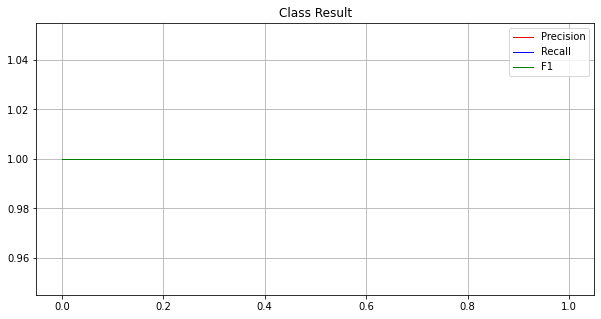

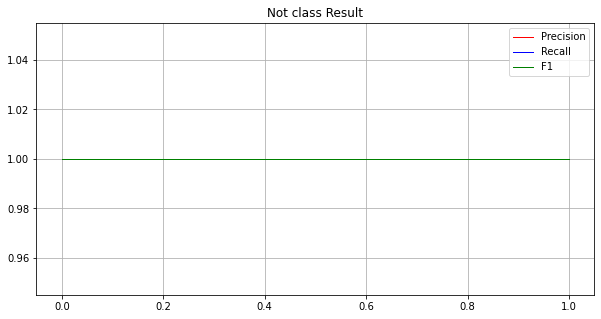

In [321]:
plot_results(train_docs, min_threshold=0, max_threshold=1, step=0.1, trace=1)

In [322]:
TEST_DATA_FILE  = '/content/drive/My Drive/antispam-infopoisk/kaggle_test_data_tab_new.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = list(load_csv(TEST_DATA_FILE, calc_features))



15:19:17 INFO:Complete items 00000
15:20:13 INFO:Complete items 01000
15:21:02 INFO:Complete items 02000
15:21:46 INFO:Complete items 03000
15:22:25 INFO:Complete items 04000
15:23:03 INFO:Complete items 05000
15:23:50 INFO:Complete items 06000
15:24:29 INFO:Complete items 07000
15:25:10 INFO:Complete items 08000
15:25:51 INFO:Complete items 09000
15:26:46 INFO:Complete items 10000
15:27:26 INFO:Complete items 11000
15:28:08 INFO:Complete items 12000
15:28:45 INFO:Complete items 13000
15:29:28 INFO:Complete items 14000
15:30:10 INFO:Complete items 15000
15:30:57 INFO:Complete items 16000
15:30:59 INFO:Complete items 16038


In [ ]:
len(AllTexts[7045:])

16038

In [35]:
r_a_t_pred = obr_texts(AllTexts[7045:])

100%|██████████| 16039/16039 [1:03:07<00:00,  4.23it/s]


In [36]:
with open('/content/drive/My Drive/antispam-infopoisk/text_pred2.data', 'wb') as filehandle:
    pickle.dump(r_a_t_pred,filehandle)

In [37]:
with open('/content/drive/My Drive/antispam-infopoisk/text_pred2.data', 'rb') as filehandle:
    r_a_t_pred2 = pickle.load(filehandle)

In [173]:
Idf_pred = idf(r_a_t_pred2,10)
Tf_pred = tf(r_a_t_pred2,20)

In [323]:
#добавляем усредненный idf и tf к признакам
i=0
for doc in test_docs:
  doc.features.append(Idf_pred[i].tolist()[0][0])
  doc.features.append(Tf_pred[i])
  i+=1

In [324]:
with open('/content/drive/My Drive/antispam-infopoisk/my_submission_new35.csv' , 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > 0.5 else 0
        writer.writerow([item[0], prediction])

15:31:24 INFO:Complete items 00000
15:31:24 INFO:Complete items 01000
15:31:25 INFO:Complete items 02000
15:31:26 INFO:Complete items 03000
15:31:26 INFO:Complete items 04000
15:31:27 INFO:Complete items 05000
15:31:27 INFO:Complete items 06000
15:31:28 INFO:Complete items 07000
15:31:29 INFO:Complete items 08000
15:31:29 INFO:Complete items 09000
15:31:30 INFO:Complete items 10000
15:31:31 INFO:Complete items 11000
15:31:31 INFO:Complete items 12000
15:31:32 INFO:Complete items 13000
15:31:32 INFO:Complete items 14000
15:31:33 INFO:Complete items 15000
15:31:34 INFO:Complete items 16000
